In [10]:
import zipfile
from urllib import request
import imutils
import matplotlib.image as mpimg
import random
%matplotlib inline
import cv2
from glob import glob
import keras,math
import cv2 as cv 
import pandas as pd
from keras.layers import Conv2D, UpSampling2D, InputLayer, Conv2DTranspose, Reshape ,MaxPooling2D, advanced_activations
from keras.layers import concatenate, Concatenate,Dense, Flatten,SeparableConv2D,LeakyReLU,GlobalAveragePooling2D
from keras.layers import BatchNormalization, RepeatVector, Permute, Activation, Reshape, Flatten,Multiply
from keras.layers.advanced_activations import PReLU

from keras.layers import Lambda,Add,Dropout,SpatialDropout2D,DepthwiseConv2D,normalization
from keras.models import Sequential, Model 
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.backend import clear_session
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
from keras.layers import MaxPooling2D, Input, Dense, Flatten
import numpy as np
from PIL import Image
import os
from skimage.transform import resize
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import matplotlib.gridspec as gridspec
 
import tensorflow as tf 
import keras
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
 
# aita die akta tensor e sob image k nie astasi
 
from keras.layers import  Input,Conv2D,BatchNormalization,Activation,Lambda,Subtract,concatenate,Add,merge,add
#from SpectralNormalizationKeras import DenseSN, ConvSN2D

from keras.layers import  Input,Conv2D,BatchNormalization,Activation,Lambda,Subtract,concatenate,Add,merge,add
#from SpectralNormalizationKeras import DenseSN, ConvSN2D

 
 
from keras.optimizers import Adam 

# Dataset loading

In [19]:
x_train = np.load('train_im.npy')
y_train = np.load('train_lb.npy')
x_test = np.load('test_im.npy')

re=list()

for i in range(len(y_train)):
    a=y_train[i]
    b=np.expand_dims(a, axis = 2)
    re.append(b)


re=np.asarray(re)
x_label=re 

print(x_train.shape, x_label.shape)
print(x_test.shape )


(670, 128, 128, 3) (670, 128, 128, 1)
(65, 128, 128, 3)


In [44]:
 
def dice_coef(y_true, y_pred):
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    intersection = K.sum(y_true * y_pred)
    return (2. * intersection + K.epsilon()) / (K.sum(y_true) + K.sum(y_pred) + K.epsilon())
 
def plot_sample(lr, sr):
    plt.figure(figsize=(10, 8))

    images = [lr, sr]
    titles = ['recovered map', 'input image']

    for i, (img, title) in enumerate(zip(images, titles)):
        plt.subplot(1, 2, i+1)
        plt.imshow(img,cmap='gray')
        plt.title(title)
        plt.xticks([])
        plt.yticks([])
def imgps(x):
    p = x[0] * 255
    p = p.astype(np.uint8)
    p = Image.fromarray(p)
    return p

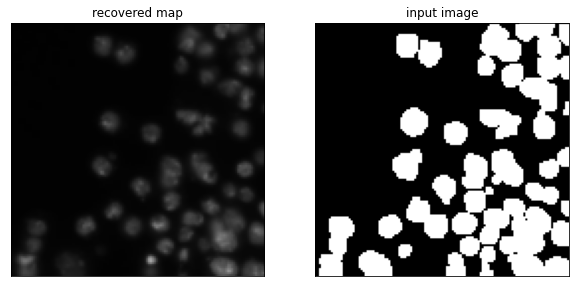

In [45]:
ind=6
a=x_train[ind] 
b=x_label[ind]
b=np.squeeze(b)
plot_sample(a,b)

In [25]:
def enc_cnv_block(inp, fe, fil = (3, 3),conv_strides = 1, pool_size = (2, 2), pool_strides = (2, 2)):
    
    
        conv1 = Conv2D(fe , fil , activation = 'relu', strides = conv_strides,padding = 'same', 
                                                       kernel_initializer = 'he_normal')(inp)
        
        conv2 = Conv2D(fe , fil , activation = 'relu', strides = conv_strides,padding = 'same',
                                                       kernel_initializer = 'he_normal')(conv1)
        
        pool = MaxPooling2D(pool_size, strides = pool_strides)(conv2)

        return pool, conv2

    # decoding block(concat - upconv - upconv)
def dec_cnv_block(  inp, merge_inp, fe, fil = (3, 3), conv_strides = 1,up_conv_strides = (2, 2)):
    

        merge = Concatenate(axis = 3)([Conv2DTranspose(fe, fil,
                activation = 'relu', strides = up_conv_strides, kernel_initializer = 'he_normal',
                padding = 'same')(inp), merge_inp])

        conv1 = Conv2D(fe , fil , activation = 'relu', strides = conv_strides,
                padding = 'same', kernel_initializer = 'he_normal')(merge)
        
        
        conv2 = Conv2D(fe , fil , activation = 'relu', strides = conv_strides,
                padding = 'same', kernel_initializer = 'he_normal')(conv1)

        return conv2

    # encoder
def encoding_path( inputs):

        enc_conv1, concat1 = enc_cnv_block(inputs, 64)
        enc_conv2, concat2 = enc_cnv_block(enc_conv1, 128)
        enc_conv3, concat3 = enc_cnv_block(enc_conv2, 256)
        enc_conv4, concat4 = enc_cnv_block(enc_conv3, 512)

        return concat1, concat2, concat3, concat4, enc_conv4

    # decoder
def decoding_path(dec_inputs, concat1, concat2, concat3, concat4):

        dec_conv1 = dec_cnv_block(dec_inputs, concat4, 512)
        dec_conv2 = dec_cnv_block(dec_conv1, concat3, 256)
        dec_conv3 = dec_cnv_block(dec_conv2, concat2, 128)
        dec_conv4 = dec_cnv_block(dec_conv3, concat1, 64)

        return dec_conv4

In [26]:
w=128
input_img = Input(shape=(w,w,3))
concat1, concat2, concat3, concat4, enc_path = encoding_path(input_img)

        # middle path
mid_path1 = Conv2D(1024, (3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(enc_path)
mid_path1 = Dropout(.5)(mid_path1)
mid_path2 = Conv2D(1024, (3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(mid_path1)
mid_path2 = Dropout(.5)(mid_path2)

        # Expanding path
dec_path = decoding_path(mid_path2, concat1, concat2, concat3, concat4)
x = Conv2D(1, (1,1), activation ='sigmoid', padding = 'same', kernel_initializer = 'glorot_normal')(dec_path)

 
 

model = Model(input_img, x)

In [27]:
model.compile(optimizer = Adam(lr=2e-4) ,
                          loss = 'binary_crossentropy', metrics = [dice_coef])

In [7]:
 

filepath="B_seg1.hdf5"
checkpoint = ModelCheckpoint(filepath, 
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=False, 
                             mode='min')

In [28]:
model.fit(x_train, x_label, validation_split = .2, epochs = 70000, batch_size = 8, shuffle =  True, callbacks =  [checkpoint ])

Train on 536 samples, validate on 134 samples
Epoch 1/70000
536/536 [==============================] - 16s 31ms/step - loss: 2.5220 - dice_coef: 0.5361 - val_loss: 0.4109 - val_dice_coef: 0.7013

Epoch 00001: saving model to B_seg1.hdf5
Epoch 2/70000
536/536 [==============================] - 10s 20ms/step - loss: 0.5834 - dice_coef: 0.7256 - val_loss: 0.3433 - val_dice_coef: 0.7737

Epoch 00002: saving model to B_seg1.hdf5
Epoch 3/70000
536/536 [==============================] - 10s 20ms/step - loss: 0.6452 - dice_coef: 0.7384 - val_loss: 0.6229 - val_dice_coef: 0.6356

Epoch 00003: saving model to B_seg1.hdf5
Epoch 4/70000
536/536 [==============================] - 11s 20ms/step - loss: 0.6427 - dice_coef: 0.7449 - val_loss: 0.2143 - val_dice_coef: 0.8105

Epoch 00004: saving model to B_seg1.hdf5
Epoch 5/70000
536/536 [==============================] - 11s 20ms/step - loss: 0.2527 - dice_coef: 0.8182 - val_loss: 0.1592 - val_dice_coef: 0.8321

Epoch 00005: saving model to B_seg1.hdf5

536/536 [==============================] - 11s 20ms/step - loss: 0.0869 - dice_coef: 0.8961 - val_loss: 0.0924 - val_dice_coef: 0.8938

Epoch 00043: saving model to B_seg1.hdf5
Epoch 44/70000
536/536 [==============================] - 11s 20ms/step - loss: 0.5030 - dice_coef: 0.7754 - val_loss: 0.9462 - val_dice_coef: 0.4553

Epoch 00044: saving model to B_seg1.hdf5
Epoch 45/70000
536/536 [==============================] - 11s 20ms/step - loss: 0.5162 - dice_coef: 0.6644 - val_loss: 0.1666 - val_dice_coef: 0.7519

Epoch 00045: saving model to B_seg1.hdf5
Epoch 46/70000
536/536 [==============================] - 11s 20ms/step - loss: 0.1805 - dice_coef: 0.7753 - val_loss: 0.1251 - val_dice_coef: 0.8251

Epoch 00046: saving model to B_seg1.hdf5
Epoch 47/70000
536/536 [==============================] - 11s 20ms/step - loss: 0.1356 - dice_coef: 0.8200 - val_loss: 0.1071 - val_dice_coef: 0.8377

Epoch 00047: saving model to B_seg1.hdf5
Epoch 48/70000
536/536 [==============================]

KeyboardInterrupt: 

In [32]:
model.save('B_seg1.h5')   


## Testing

In [33]:
val=x_test

In [34]:
val.shape

(65, 128, 128, 3)

In [37]:
model.load_weights('B_seg1.h5')
per =  model.predict(val)
 

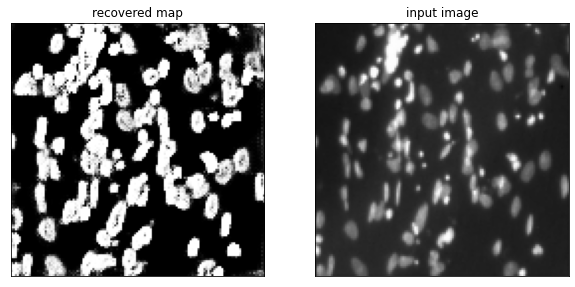

In [48]:
i=21
 
p=per[i]  
p= np.squeeze(p)
p=p.astype('float32')
 
q=val[i]
plot_sample( p,q)